In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astroquery.gaia import Gaia

In [2]:
OC = 'NGC_2682'

In [36]:
#step0: match apogee data with gaia data
hdul = fits.open('apogee.fits')
apogee_data = hdul[1].data

TEFF = apogee_data["TEFF"]
TEFF_ERR = apogee_data["TEFF_ERR"]
apogee_id = apogee_data['APOGEE_ID']
TM_ID=[]
Teff=[]
Teff_err=[]
for i,ID in enumerate(apogee_id):
    if '2M' in ID and TEFF[i]>0:
        TM_ID.append(ID.split('M')[1])
        Teff.append(TEFF[i])
        Teff_err.append(TEFF_ERR[i])
apogee_df = pd.DataFrame({'tm_ID':TM_ID,'Teff':Teff,'Teff_err':Teff_err})

if OC == 'NGC_2682':
    xmatch_data = Table.read('k2_dr2_1arcsec.fits', format='fits')
xmatch_df = xmatch_data.to_pandas()
xmatch_df = xmatch_df[['solution_id','source_id','tm_name']]
xmatch_df.drop_duplicates(inplace=True)
xmatch_df['tm_name'] = xmatch_df['tm_name'].str.decode("utf-8")
xmatch_tm_ID = []
for ID in xmatch_df['tm_name']:
    if 'J' in ID:
        xmatch_tm_ID.append(ID.split('J')[1])
    else:
        xmatch_tm_ID.append(None)
xmatch_df['tm_ID'] = xmatch_tm_ID
apogee_gaia = pd.merge(xmatch_df, apogee_df, how='left', on='tm_ID')
print(len(apogee_gaia.index))

apogee_Teff = apogee_gaia[['source_id','Teff','Teff_err']].copy()
apogee_Teff.dropna(subset=['Teff'],inplace=True)
apogee_Teff.rename(columns={'source_id':'ID'},inplace=True)
print(len(apogee_Teff.index))

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: TableReplaceWarning: converted column 'k2_kepmagerr' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


328589
2609


In [17]:
#step 1: get members in gaia IDs and write a simbad input file
def load_M67(num=True,array=True):
    data = open("M67 membership.txt", "r").read()
    data = data.split("\n")
    for i in range(len(data)):
        data[i] = data[i].split("  ")[:-1]
        if num==True:
            for j in range(len(data[i])):
                data[i][j] = float(data[i][j])
    if array == True:
        return np.array(data)
    else:
        return data

def load_cluster(OC):
    df = pd.read_csv('GAIA OC membership data.csv')
    OC_list = df['cluster'].unique()
    if OC not in OC_list:
        print("{} - is not a cluster in this data set".format(OC))
    else:
        return df[df['cluster']==OC]

def genSimbad(OC):
    simbad_template = open('SIMBAD_template.txt','r').read().split('\n')
    if OC=='NGC_2682':
        OC_mem = load_M67()
        gaia_IDs = OC_mem[:,0]
    else:
        OC_mem = load_cluster(OC)
        gaia_IDs = list(OC_mem['ID'])
    simbad_input = simbad_template[0]+'\n'
    for star in gaia_IDs:
        simbad_input+=('GAIA DR2 '+str(int(star))+'\n')
    simbad_input+=simbad_template[1]
    f = open("{}/{}_simbad_input.txt".format(OC,OC), 'w')
    f.write(simbad_input)
    f.close()
    return gaia_IDs

gaia_IDs = genSimbad(OC)

In [26]:
#step 2: astroquery for gaia Gband mags, luminosities and distances
def GAIA_query(ids):
    if type(ids[0]) is not str:
        ids = [str(int(i)) for i in ids]
    query_ids = ",".join(ids)
    r= Gaia.launch_job("SELECT TOP 5000 gaia_source.source_id, gaia_source.phot_g_mean_mag, \
    gaia_source.phot_g_mean_flux, gaia_source.phot_g_mean_flux_error, gaia_source.lum_val, gaia_source.lum_percentile_lower, \
    gaia_source.lum_percentile_upper, dist.source_id as dist_id, dist.r_est, dist.r_lo, dist.r_hi \
    FROM gaiadr2.gaia_source, external.gaiadr2_geometric_distance as dist \
    WHERE gaia_source.source_id=dist.source_id and gaia_source.source_id in ({});".format(query_ids))
    r = r.get_results()
    g_mag_err = 1.085736205*np.array(r['phot_g_mean_flux_error'])/np.array(r['phot_g_mean_flux'])
    lum_err = np.maximum(np.array(r['lum_percentile_lower']),np.array(r['lum_percentile_upper']))
    dist_err = np.maximum(np.array(r['r_lo']),np.array(r['r_hi']))
    df = pd.DataFrame({'ID':r['source_id'],'g_mag':r['phot_g_mean_mag'],'g_mag_err':g_mag_err,'gaia_lum':r['lum_val'],
                       'gaia_lum_err':lum_err,'distance':r['r_est'],'distance_err':dist_err})
    return df
    
gaia_df = GAIA_query(gaia_IDs)

In [41]:
#step 3: merging apogee_gaia df with gaia_df
step3_df = pd.merge(gaia_df, apogee_Teff, how='left', on='ID')
ref = []
for star in step3_df['Teff']:
    if star>0:
        ref.append('apogee')
    else:
        ref.append(np.nan)
step3_df['ref'] = ref

In [59]:
#step 4: read simbad output file and combine it to step3_df
file = f'{OC}/{OC}_simbad_output.txt'
collected_data = open(file,'r').read().split(':\n')[-1]
first_lines = collected_data.split('\nGAIA')
lines = []
for line in first_lines:
    lines+=line.split('\nGaia')
lines = lines[1:]
print('found',len(lines),'matching IDs')

all_data = []
for i,line in enumerate(lines):
    if 'DR2' in line and 'Fe_H' in line:
        ID, feh_list = line.split('|Fe_H')
        ID = ID.split(' ')[2]
        data_dict={}
        data_dict['ID'] = int(ID)

        if '\n' in feh_list:
            feh_list=feh_list.split('\n')
        else:
            feh_list = [feh_list]
        feh_array = []
        for feh in feh_list:
            feh = feh.split('|')[1:-1]
            feh = [fehi.strip() for fehi in feh]
            try: a=len(feh[0])
            except IndexError: print(line,feh)
            if len(feh[0])>0:
                if ' ' in feh[0]:
                    Teff = float(feh[0].split(' ')[0])
                    if Teff<1000:
                        continue
                else:
                    if float(feh[0])>1000:
                        Teff = float(feh[0])
                    else: continue
            else: continue
            if len(feh[1])>0:
                try: FeH = float(feh[1])
                except ValueError: FeH = None
            else:
                FeH = None

            ref = feh[-1]
            if float(ref[:4])<2000:
                continue
            ref_list = []
            if len(feh_array)>0:
                for f in feh_array:
                    ref_list.append(f[2])
                if ref in ref_list:
                    continue
            feh_array.append([Teff, FeH, ref])

        if len(feh_array)==0:
            continue
        data_dict['feh_table'] = feh_array
        all_data.append(data_dict)

print(len(all_data),'stars have Teff data')
simbad_df = pd.DataFrame(all_data)
length=[]
for i in list(df['feh_table']):
    length.append(len(i))
simbad_df['feh_count'] = length
step4_df = pd.merge(step3_df, simbad_df, how='left', on='ID')

indicator = []
for i,star in step4_df.iterrows():
    if np.isnan(star['Teff'])==True and np.isnan(star['feh_count'])==True:
        indicator.append(np.nan)
    else: indicator.append('keep')
step4_df['indicator'] = indicator
step4_df.dropna(subset=['indicator'],inplace=True)
print('Found Teff for',len(step4_df.index),'stars between SIMBAD and APOGEE.')

found 1502 matching IDs
155 stars have Teff data
Found Teff for 163 stars between SIMBAD and APOGEE.


In [56]:
def countUniqueRefs(df, column='feh_table'):
    ref_list = []
    if column=='feh_table':
        for i in df['feh_table']:
            refs = []
            for j in i:
                refs.append(j[2])
            refs=list(set(refs))
            ref_list+=refs
    elif column=='refs':
        ref_list = df['refs']
    print(len(ref_list))
    ref_set = set(ref_list)
    ref_count = np.zeros(len(ref_set))
    for i in ref_list:
        for j,r in enumerate(ref_set):
            if i==r:
                ref_count[j]+=1
    ref_df = pd.DataFrame({'ref':list(ref_set),'count':ref_count})
    ref_df.sort_values('count',inplace=True,ascending=False,ignore_index=True)
    return ref_df

def replaceByRef(df, target_ref):
    non_hits = []
    for i,star in df.iterrows():
        if star['Teff']>0:
            continue
        else:
            refs = []
            hit = False
            for paper in star['feh_table']:
                if target_ref == paper[2]:
                    df['Teff'][i] = paper[0]
                    df['refs'][i] = paper[2]
                    hit=True
                    break
            if hit == False:
                non_hits.append(star['ID'])
    return df, non_hits

In [6]:
#read in csv and turn feh_table from string to list
full_df = pd.read_csv(f'{OC}/GAIA-OC-membership-{OC}.csv')
feh_tables = []
for i in full_df['feh_table']:
    i=i[2:-2].split('], [')
    refs=[]
    for j in i:
        j=j.split(', ')
        j[0] = float(j[0])
        if j[1]=='None':
            j[1]=None
        else: j[1] = float(j[1])
        j[2] = j[2][1:-1]
        refs.append(j)
    feh_tables.append(refs)
full_df['feh_table'] = feh_tables

In [7]:
#assign Teff and ref for stars that only have one source of Teff
Teff = []
refs = []
for star in feh_tables:
    if len(star)==1:
        Teff.append(star[0][0])
        refs.append(star[0][2])
    else:
        Teff.append(None)
        refs.append(None)
full_df['Teff'] = Teff
full_df['refs'] = refs

In [75]:
#assign Teff and ref for stars that have multiple sources but sources agree with each other
#criteria = max(source_Teff-median_Teff)<90
#paper is chosen by number of stars it supply. The paper that supplies most stars gets used first
multiples = full_df[full_df['feh_count']>1].copy()
singulars = full_df[full_df['feh_count']==1].copy()
problematic_IDs=[]
regular_IDs=[]
for i,star in multiples.iterrows():
    Teffs = []
    for paper in star['feh_table']:
        Teffs.append(paper[0])
    median = np.median(Teffs)
    diff = np.array(Teffs)-median
    if max(diff)>90:
        problematic_IDs.append(star['ID'])
    else: regular_IDs.append(star['ID'])
problematic_df = multiples[multiples['ID'].isin(problematic_IDs)].copy()
regular_df = multiples[multiples['ID'].isin(regular_IDs)].copy()

rank = countUniqueRefs(regular_df)
ref_length=np.sum(rank['count'])
ranks=[]
while ref_length>0:
    index = np.where(rank['count']==rank['count'][0])[0]
    if len(index)>1:
        papers = np.array(rank['ref'])[index]
        years = []
        for p in papers:
            years.append(int(p[:4]))
        target_paper = papers[np.argmax(years)]
    else:
        target_paper = rank['ref'][0]
    
    regular_df,other_ID = replaceByRef(regular_df,target_paper)
    rank = countUniqueRefs(regular_df[regular_df['ID'].isin(other_ID)])
    ranks.append(rank)
    ref_length = np.sum(rank['count'])

229
137
54
25
14
10
2
0


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [62]:
countUniqueRefs(pd.concat([regular_df,singulars]),column='refs')

144


,ref,count
0,2011AJ....141...89S,68.0
1,2016ApJ...823..114N,23.0
2,2013AJ....146..134K,19.0
3,2016A&A...589A.115S,14.0
4,2009A&A...493..309S,5.0
5,2006A&A...450..557R,4.0
6,2000AJ....120.1913S,4.0
7,2011AJ....142...59J,2.0
8,2016A&A...594A..43H,2.0
9,2018A&A...620A..58S,1.0


In [64]:
#manually choosing the Teff for the stars that have sources that do not agree with each other
problematic_df['Teff'][14]=4740
problematic_df['refs'][14]='2016ApJ...823..114N'
problematic_df['Teff'][47]=5810
problematic_df['refs'][47]='2011AJ....141...89S'
problematic_df['Teff'][73]=5846
problematic_df['refs'][73]='2013AJ....146..134K'
problematic_df['Teff'][83]=5741
problematic_df['refs'][83]='2011AJ....141...89S'
problematic_df['Teff'][87]=4778
problematic_df['refs'][87]='2016ApJ...823..114N'
problematic_df['Teff'][89]=4186
problematic_df['refs'][89]='2011A&A...531A.165P'
problematic_df['Teff'][93]=5729
problematic_df['refs'][93]='2013AJ....146..134K'
problematic_df['Teff'][95]=5927
problematic_df['refs'][95]='2011AJ....141...89S'
problematic_df['Teff'][118]=4400
problematic_df['refs'][118]='2011AJ....142...59J'
problematic_df['Teff'][149]=6170
problematic_df['refs'][149]='2000AJ....120.1913S'

problematic_df

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we c

,ID,V_mag,V_error,feh_table,feh_count,ra,ra_error,dec,dec_error,parallax,parallax_error,phot_g_mean_mag,luminosity,membership probability,Teff,refs
14,604918144751101440,10.441,0.048,"[[4812.0, 0.03, 2009A&A...493..309S], [4700.0,...",6,132.870748,0.037252,11.842522,0.024230,1.202100,0.046694,10.233725,48.231815,1.000,4740.0,2016ApJ...823..114N
47,604914949295282816,14.676,0.156,"[[5970.0, 0.0, 2018A&A...620A..58S], [5759.0, ...",5,132.753308,0.027932,11.814654,0.023868,1.116411,0.036939,14.466602,0.974529,1.000,5810.0,2011AJ....141...89S
73,604917285757662592,13.189,0.085,"[[6151.0, 0.0, 2006A&A...450..557R], [5846.0, ...",2,132.841831,0.021916,11.778045,0.013773,1.175754,0.028590,13.062797,3.224528,1.000,5846.0,2013AJ....146..134K
83,604910860486613632,14.053,0.064,"[[6508.0, None, 2013AJ....146..134K], [5741.0,...",3,132.773937,0.024119,11.729702,0.016226,1.088750,0.031193,13.886260,1.749183,1.000,5741.0,2011AJ....141...89S
87,604920202039656064,10.463,0.036,"[[4862.0, 0.01, 2009A&A...493..309S], [4730.0,...",6,132.997963,0.040971,11.917997,0.028605,1.121971,0.054322,10.205662,57.288364,1.000,4778.0,2016ApJ...823..114N
89,604911375882674560,9.603,0.022,"[[4250.0, -0.02, 2000A&A...360..499T], [4200.0...",5,132.822809,0.035909,11.756296,0.022113,1.187637,0.044853,9.252860,143.450870,1.000,4186.0,2011A&A...531A.165P
93,604917487620349184,13.069,0.040,"[[6223.0, 0.07, 2006A&A...450..557R], [5729.0,...",2,132.822231,0.029522,11.783506,0.018589,1.175260,0.037143,12.952729,3.488725,1.000,5729.0,2013AJ....146..134K
95,604970783870102656,14.247,0.101,"[[5646.0, None, 2013AJ....146..134K], [5927.0,...",3,132.743677,0.022747,11.994293,0.014292,1.169916,0.027687,14.085518,1.262268,1.000,5927.0,2011AJ....141...89S
118,604917594995372544,10.316,0.039,"[[4450.0, -0.05, 2000A&A...360..499T], [4400.0...",6,132.821199,0.036131,11.804480,0.021249,1.135831,0.044124,9.917629,80.095810,0.999,4400.0,2011AJ....142...59J
149,604911337227185920,12.315,0.039,"[[5963.0, 0.06, 2018MNRAS.480.4314B], [6170.0,...",2,132.838381,0.042892,11.764643,0.028695,1.143425,0.057739,12.121811,7.965503,0.923,6170.0,2000AJ....120.1913S


In [72]:
#the final product
final_df = pd.concat([singulars,regular_df,problematic_df])
final_df.sort_index(inplace=True)

In [74]:
final_df.to_csv(f'{OC}/GAIA-OC-membership-{OC}.csv',index=False)

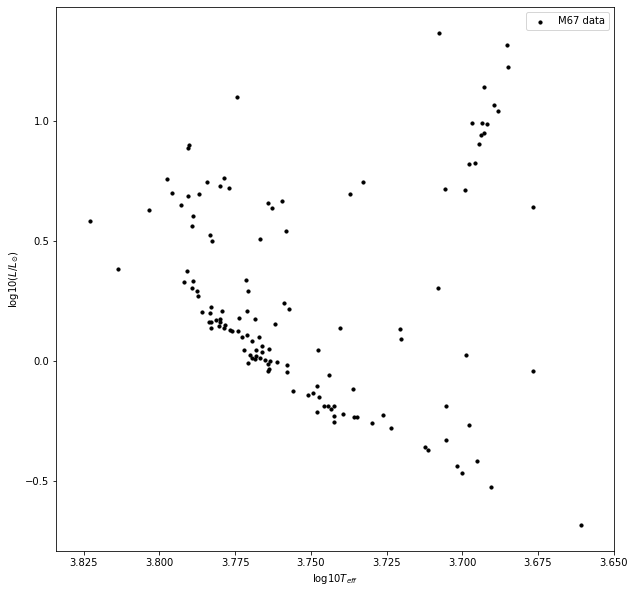

In [87]:
final_df['value'] = 10*np.log10(final_df['Teff'])-np.log10(final_df['luminosity'])-35.5
cut_df = final_df[final_df['value']>0].copy()
cut_df.drop(index=final_df[final_df['ID'].isin([604911135364519808,604989372488540416])].index,inplace=True)
fig, ax=plt.subplots(1,1, figsize=(10,10))
ax.scatter(np.log10(cut_df['Teff']), np.log10(cut_df['luminosity']), s=10, zorder=3, c='black', label='M67 data')
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel(r'$\log10 T_{eff}$')
ax.set_ylabel(r'$\log10(L/L_{\odot})$')
ax.legend()
plt.show()

In [91]:
#cut_df.drop(columns=['value'],inplace=True)
cut_df.to_csv(f'{OC}/GAIA-OC-membership-{OC}_final.csv',index=False)

In [93]:
import gaia_tools.load

ModuleNotFoundError: No module named 'gaia_tools'